Current working directory: /home/astro/Documents/GitHub/ALMASim/experimental
Path to the parent directory: /home/astro/Documents/GitHub/ALMASim/experimental/..


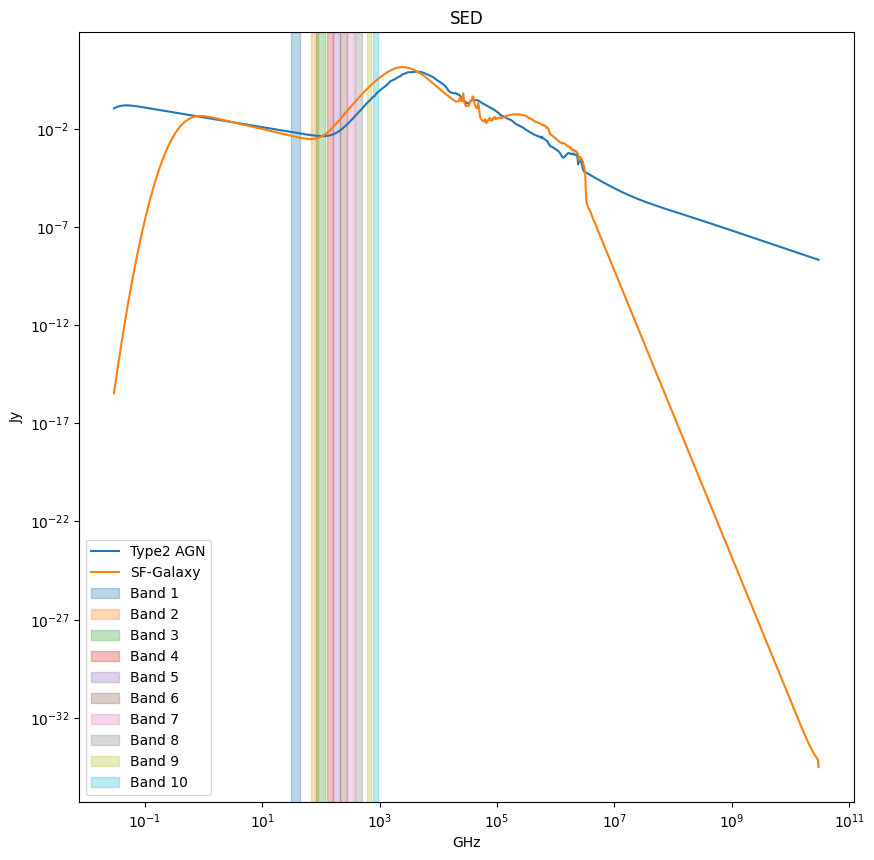

Mean Continum: 0.014852465147206208
Line CO(2-1) has a flux of 0.13497151571007035
Line CH3OH(5-4) has a flux of 0.14167230213301152
Line CH3OH(6-5) has a flux of 0.1719941231307095
Line SO(7-6) has a flux of 0.1022759463484459


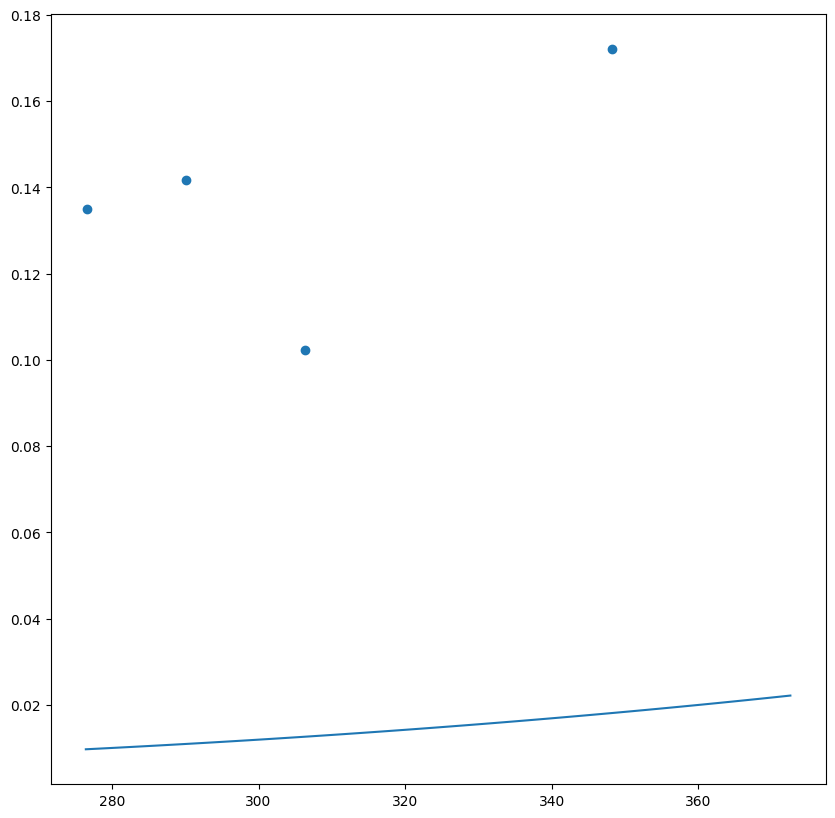

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as U
from scipy.constants import c
import sys
from math import pi

current_dir = os.getcwd()

def sed_reading(type_, path, lum_infrared=None, redshift=None):
    cosmo = FlatLambdaCDM(H0=70 * U.km / U.s / U.Mpc, Tcmb0=2.725 * U.K, Om0=0.3)
    if type_ == "extended" or type_ == 'diffuse':
        file_path = os.path.join(path, 'SED_low_z_warm_star_forming_galaxy.dat')
        if redshift is None:
            redshift = 10**(-4)
        if lum_infrared is None: 
            lum_infrared = 1e+10 # luminosity in solar luminosities
    elif type_ == "point" or type_ == "gaussian":
        file_path = os.path.join(path, 'SED_low_z_type2_AGN.dat')
        if redshift is None:
            redshift = 0.05
        if lum_infrared is None:
            lum_infrared = 1e+9 # luminosity in solar luminosities
    else:
        return "Not valid type"
    # Compute luminosity distance in Mpc
    distance_Mpc = cosmo.luminosity_distance(redshift).value # distance in Mpc
    Mpc_to_cm = 3.086e+24 # Mpc to cm
    distance_cm = distance_Mpc * Mpc_to_cm # distance in cm  -XX
    solid_angle = 4 * pi  * distance_cm**2 # solid angle in cm^2 -XX
    so_to_erg_s = 3.846e+33 # Solar luminosity to erg/s -XX
    lum_infrared_erg_s = lum_infrared * so_to_erg_s # luminosity in erg/s -XX
    
    # Load the SED
    sed = pd.read_csv(file_path, sep="\s+")
    # Convert to GHz
    sed['GHz'] = sed['um'].apply(lambda x: (x* U.um).to(U.GHz, equivalencies=U.spectral()).value)
    # Re normalize the SED and convert to Jy from erg/s/Hz
    sed['Jy'] = lum_infrared_erg_s * sed['erg/s/Hz'] * 1e+23 / solid_angle
    #  Flux (Jy) =L (erg/s/Hz) * 10^23 /  * 4 pi d^2(cm)
    flux_infrared = lum_infrared_erg_s * 1e+23 / solid_angle # Jy * Hz 
    #flux_infrared_jy = flux_infrared  / (sed['GHz'].values * U.GHz).to(U.Hz).value  # Jy
    sed.drop(columns=['um', 'erg/s/Hz'], inplace=True)
    sed = sed.sort_values(by='GHz', ascending=True) 
    return sed, flux_infrared

sed_point, flux_infrared_point = sed_reading("point", os.path.join(current_dir, 'brightnes'), lum_infrared=1e+12, redshift=0.05)
sed_extended, flux_infrared_ext = sed_reading("extended", os.path.join(current_dir, 'brightnes'), lum_infrared=1e+12, redshift=0.05)

def cont_finder(sed,line_frequency):
    cont_frequencies=sed['GHz'].values
    distances = np.abs(cont_frequencies - np.ones(len(cont_frequencies))*line_frequency)
    return np.argmin(distances)


alma_bands = [au.get_band_range(i) for i in range(1, 11)]
color_map = plt.colormaps.get_cmap('tab10')

plt.figure(figsize=(10,10))
plt.plot(sed_point['GHz'], sed_point['Jy'], label='Type2 AGN')
plt.plot(sed_extended['GHz'], sed_extended['Jy'], label='SF-Galaxy')
plt.xlabel('GHz')
plt.ylabel('Jy')
plt.title('SED')
plt.xscale('log')
plt.yscale('log')
for i in range(len(alma_bands)):
    color = color_map(i)
    plt.axvspan(alma_bands[i][0], alma_bands[i][1], color=color, alpha=0.3, label=f'Band {i + 1}')
plt.legend()
plt.show()

# Let's procede with only the AGN SED

redshift = 0.2
band = 6
# Get band Central Frequency
central_frequency = au.get_band_central_freq(band)
# Load Line Database
db_line = asu.read_line_emission_csv(os.path.join(parent_dir,'brightnes','calibrations_FIR(GHz).csv'))
# Shift the SED to the given redshift
sed_point['GHz'] = sed_point['GHz'] * (1 + redshift)
# Get limits of the ALMA Band
freq_min, freq_max = alma_bands[band][0], alma_bands[band][1]
# Shift Line Frequencies with Redshift
db_line['shifted_freq(GHz)'] = db_line['freq(GHz)'] * (1 + redshift)
# Select lines that fall in the ALMA Band
line_mask = (db_line['shifted_freq(GHz)'].astype(float) >= freq_min) & (db_line['shifted_freq(GHz)'].astype(float) <= freq_max)
filtered_lines = db_line[line_mask]
# Select continuum frequencies that fall in the ALMA Band
cont_mask = (sed_point['GHz'] >= freq_min) & (sed_point['GHz'] <= freq_max)
cont_fluxes = sed_point[cont_mask]['Jy'].values
cont_frequencies = sed_point[cont_mask]['GHz'].values


line_names = filtered_lines['Line'].values
cs = filtered_lines['c'].values
# Get the index of the continuum where the line fall
line_indexes = filtered_lines['shifted_freq(GHz)'].apply(lambda x: cont_finder(sed_point[cont_mask], float(x)))
# Line Flux (integrated over the line) = Cont_flux + 10^(log(L_infrared / line_width_in_Hz) + c)
line_frequencies =  (filtered_lines['shifted_freq(GHz)'].values * U.GHz).to(U.Hz).value
freq_steps = np.array([cont_frequencies[line_index + 1] - cont_frequencies[line_index] for line_index in line_indexes]) * U.GHz
freq_steps = freq_steps.to(U.Hz).value
line_fluxes = cont_fluxes[line_indexes] + 10**(np.log10(flux_infrared_point / freq_steps) + cs)
print('Mean Continum: {}'.format(np.mean(cont_fluxes)))
for flux, name in zip(line_fluxes, line_names):
    print('Line {} has a flux of {}'.format(name, flux))
plt.figure(figsize=(10, 10))
plt.plot(cont_frequencies, cont_fluxes)
plt.scatter(filtered_lines['shifted_freq(GHz)'].values , line_fluxes, label='Line Peak')
plt.show()


